# Example: Emotion Feature Extraction With Mexca

**Requirements**: The mexca base package must be installed. No additional components are needed since this example works with the containerized components. The mexca base package can be install with the command `!pip install mexca`.

In this notebook, we will use the US presidential debate between Clinton and Trump in 2016 as an example to extract and compare emotion expressions with **mexca**. The video can be found on [YouTube](https://www.youtube.com/watch?v=DBhrSdjePkk), but we will use a file that is hosted by a third party. In contrast to the `demo.ipynb` notebook, we will dive deeper into different options and arguments that **mexca** provides and put more emphasis on analyzing the pipeline output.

In [1]:
import logging
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from IPython.display import Video
from urllib.request import urlopen
from mexca.container import AudioTranscriberContainer, FaceExtractorContainer, SentimentExtractorContainer, SpeakerIdentifierContainer, VoiceExtractorContainer
from mexca.pipeline import Pipeline

If not already done, we first need to download the video file:

In [2]:
def download_example(url, filename):
    # Check if filename exists
    if not os.path.exists(filename):
        video = urlopen(url)

        with open(filename, 'wb') as file:
            file.write(video.read())

In [3]:
example_url = 'https://books.psychstat.org/rdata/data/debate.mp4'
filename = 'debate.mp4'

download_example(example_url, filename)

Video(filename)

## Building the Pipeline

Next, we build the pipeline by combining different steps for video, audio, and text processing. To detect and extract features from faces shown in the video, we include a `FaceExtractorContainer` object. This object will call a container of the `FaceExtractor` class which already includes all requirements (dependencies and pretrained models). From a quick inspection of the video, we can guess that mostly two faces will be shown (Clinton's and Trump's), so we set `num_faces=2`. This means that detected faces will be assigned to two clusters based on their encoded representations (embeddings). In the current version of **mexca**, setting this argument is important as too many or too few face clusters might be chosen automatically otherwise.

In [4]:
n_clusters = 2

face_extractor = FaceExtractorContainer(num_faces=n_clusters)

For the audio processing, we create two components: The `SpeakerIdentifierContainer` detects speech segmenets in the audio signal and assigns them to speaker clusters. As with the faces, we assume that the video has two speakers, so we set `num_speakers=2`.

*Note*: mexca builds on pretrained models from the pyannote.audio package. Since release 2.1.1, downloading the pretrained models requires the user to accept two user agreements on Hugging Face hub and generate an authentication token. Therefore, to run the mexca pipeline, please accept the user agreements on [here](https://huggingface.co/pyannote/speaker-diarization) and [here](https://huggingface.co/pyannote/segmentation). Then, generate an authentication token [here](https://huggingface.co/settings/tokens). Use this token as the value for `use_auth_token` (instead of `"HF_TOKEN"`).

In [5]:
speaker_identifier = SpeakerIdentifierContainer(
    num_speakers=n_clusters,
    use_auth_token="HF_TOKEN" # Replace this string with your token
)

The `VoiceExtractorContainer` calculates the voice pitch (fundamental frequency F0) which is an emotion expression feature.

In [6]:
voice_extractor = VoiceExtractorContainer()

To extract the sentiment from the spoken text, we create two text processing components. First, we transcribe the audio signal to text using the `AudioTranscriber` class. The component automatically detects the spoken language of each speech segment. The transcribed text is split into single sentences.

In [7]:
audio_transcriber = AudioTranscriberContainer()

Second, the `SentimentExtractor` predicts a positive, negative, and neutral sentiment score for each sentence.

In [8]:
sentiment_extractor = SentimentExtractorContainer()

Now, we combine the five components into a `Pipeline` instance, which will run them after each other and integrate the results.

In [9]:
pipeline = Pipeline(
    face_extractor=face_extractor,
    speaker_identifier=speaker_identifier,
    voice_extractor=voice_extractor,
    audio_transcriber=audio_transcriber,
    sentiment_extractor=sentiment_extractor
)

To track the progress of the pipeline, we create a logger from the `logging.yml` file in this directory.

In [10]:
with open('logging.yml', 'r', encoding='utf-8') as file:
    config = yaml.safe_load(file)
    logging.config.dictConfig(config)

To run the pipeline, we call the `apply()` method. The video has a frame rate of 25 and to speed up the processing, we choose to process 5 video frames at at time (`frame_batch_size=5`) and to only process every 5th frame (`skip_frames=5`), assuming that emotion expressions don't change substantially faster than 200ms. For this example, we also indicate to only process the first 30 seconds using `process_subclip=(0, 30)`.

**Note**: The first time you run the pipeline with containerized components, the containers will be automatically downloaded which can take some time.

In [11]:
output = pipeline.apply(
    filename,
    frame_batch_size=5,
    skip_frames=5,
    process_subclip=(0, 30)
)

2023-11-15 09:22:30,685 - INFO - Starting MEXCA pipeline
2023-11-15 09:22:30,878 - INFO - Wrote audio file to debate.wav
2023-11-15 09:22:30,883 - INFO - Processing video frames
100%|██████████| 30/30 [01:23<00:00,  2.78s/it]

2023-11-15 09:24:05,307 - INFO - Identifying speakers
torchvision is not available - cannot save figures

2023-11-15 09:25:11,360 - INFO - Transcribing speech segments to text
/usr/local/lib/python3.9/site-packages/whisper/timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):

100%|██████████| 4/4 [00:53<00:00, 13.25s/it]


2023-11-15 09:26:11,024 - INFO - Extracting sentiment from transcribed text
100%|████████

To simplify further processing, we store the `features` attribute from the output of the pipeline which contains the integrated features as a `polars.lazyframe.frame.LazyFrame` in a separate variable.

In [12]:
output_df = output.features

We can get a quick glimpse of the output by calling polars' `describe` method. Note that some columns contain lists as row elements (e.g., `face_box`).

In [15]:
output_df.collect().describe()

describe,filename,time,frame,face_box,face_prob,face_landmarks,face_aus,face_label,face_confidence,segment_start,segment_end,segment_speaker_label,span_start,span_end,span_text,span_confidence,span_sent_pos,span_sent_neg,span_sent_neu,pitch_f0_hz,jitter_local_rel_f0,shimmer_local_rel_f0,hnr_db,f1_freq_hz,f1_bandwidth_hz,f1_amplitude_rel_f0,f2_freq_hz,f2_bandwidth_hz,f2_amplitude_rel_f0,f3_freq_hz,f3_bandwidth_hz,f3_amplitude_rel_f0,alpha_ratio_db,hammar_index_db,spectral_slope_0_500,spectral_slope_500_1500,h1_h2_diff_db,h1_f3_diff_db,mfcc_1,mfcc_2,mfcc_3,mfcc_4,spectral_flux,rms_db
str,str,f64,f64,str,f64,str,str,str,f64,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""152""",152.0,152.0,"""152""",152.0,"""152""","""152""","""152""",152.0,152.0,152.0,"""152""",152.0,152.0,"""152""",152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0,152.0
"""null_count""","""0""",0.0,0.0,"""63""",63.0,"""63""","""63""","""63""",63.0,47.0,47.0,"""47""",64.0,64.0,"""64""",64.0,64.0,64.0,64.0,71.0,71.0,71.0,152.0,1.0,1.0,152.0,1.0,1.0,152.0,5.0,5.0,152.0,1.0,152.0,1.0,1.0,71.0,152.0,0.0,0.0,0.0,0.0,1.0,0.0
"""mean""",null,14.989474,374.736842,null,0.996683,null,null,null,0.810618,15.132938,23.319884,null,17.562834,21.060561,null,0.528309,0.237491,0.288894,0.473615,213.726531,0.060978,0.184109,null,672.432458,187.251172,null,2220.185748,348.510789,null,3574.708726,490.917052,null,-2.369282,null,0.047326,-0.008527,-3.167578,null,-314.355873,133.824497,-29.597016,64.904649,0.004274,-35.708139
"""std""",null,8.666287,216.657166,null,0.019539,null,null,null,0.116494,5.979761,5.029999,null,6.49029,5.026152,null,0.416552,0.253428,0.137744,0.183132,41.433911,0.038025,0.100416,null,341.325552,239.738312,null,595.214425,242.086489,null,630.260921,328.437348,null,7.049385,null,0.022509,0.010311,8.140377,null,113.717128,76.190656,108.346838,115.777918,0.003857,9.302999
"""min""","""debate.mp4""",0.0,0.0,null,0.8157,null,null,"""0""",0.270038,8.918438,17.440313,"""0""",9.538438,15.578438,"""And then you h…",0.0,0.059763,0.047995,0.09564,113.678561,0.008097,0.047865,null,255.624777,9.538655,null,846.554166,25.281895,null,2445.888706,67.724717,null,-21.332902,null,-0.003915,-0.031503,-14.934387,null,-895.086365,-115.041228,-203.094615,-102.528307,0.00013,-100.0
"""25%""",null,7.6,190.0,null,0.99851,null,null,null,0.783391,8.918438,17.440313,null,9.538438,15.578438,null,0.0,0.133007,0.262967,0.405102,178.38108,0.029243,0.105748,null,407.606034,65.351157,null,1900.285151,184.030414,null,3074.230342,242.583557,null,-7.02552,null,0.032786,-0.015416,-8.207727,null,-324.536825,97.033363,-130.725143,-32.263058,0.00149,-38.573444
"""50%""",null,15.2,380.0,null,0.999518,null,null,null,0.843059,17.440313,27.109687,null,18.600313,21.380313,null,0.662495,0.133007,0.265088,0.562972,220.885059,0.054355,0.153564,null,571.358071,121.395222,null,2143.638194,304.586345,null,3427.477072,420.060188,null,-3.173137,null,0.044587,-0.00782,-5.261773,null,-284.972821,129.140187,-22.271449,43.906811,0.002848,-34.497085
"""75%""",null,22.4,560.0,null,0.999897,null,null,null,0.872639,17.440313,27.109687,null,24.200313,26.860312,null,0.907445,0.193538,0.370848,0.601905,245.79724,0.078572,0.238457,null,908.831059,220.033168,null,2538.15105,445.617472,null,3890.443879,646.338988,null,1.262081,null,0.064097,-0.000487,-0.462908,null,-242.909981,179.709064,53.334499,140.007686,0.005891,-29.074589
"""max""","""debate.mp4""",29.8,745.0,null,0.999997,null,null,"""1""",0.930986,27.109687,29.455313,"""1""",27.109687,29.089688,"""gold standard.…",0.942192,0.856366,0.529443,0.772027,301.019074,0.158241,0.507894,null,2027.272902,1885.294618,null,3960.474049,1585.668608,null,5262.919667,1907.58089,null,17.195592,null,0.097404,0.016199,31.215825,null,-168.838279,309.595716,204.353157,35

## Analyzing Facial Expressions

We start analyzing the output by comparing facial action unit activations between Clinton and Trump.

In [13]:
def stderr(x):
    """Calculate the standard error of the mean
    """
    return np.std(x)/np.sqrt(len(x))

In [14]:
clinton_id = 1
trump_id = 0

In [16]:
n_au = 27 # Nr of action units

# Expand action unit lists into separate rows
au_df = output_df.select(
    [
        pl.lit([list(range(27))]).alias("face_au"),
        pl.col("face_aus").alias("value").list.take(list(range(27))),
        pl.col("face_label")
    ]
).filter(pl.col("value").is_not_null()).explode(["face_au", "value"])

# Compute mean and standard error for each action unit
au_stats = (
    au_df
    .groupby('face_label', "face_au")
    .agg(
        pl.mean("value").alias("avg"),
        (pl.std("value")/pl.count().sqrt()).alias("ste")
    )
    .sort("face_au", "face_label")
)

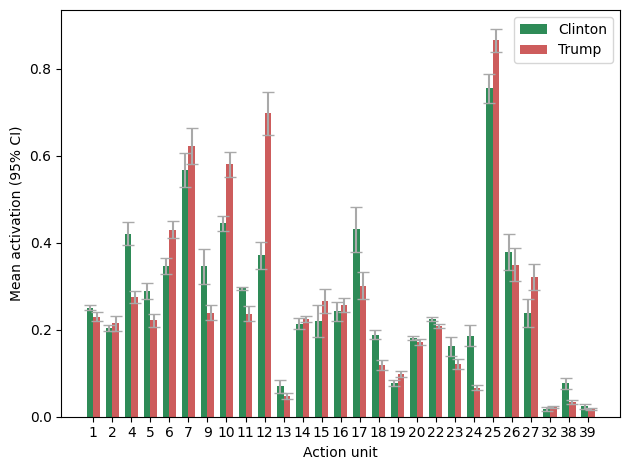

In [17]:
# Reference id of the action unit
au_ref = [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 32, 38, 39]

aus = np.arange(n_au)

# Create bar plot with error bars
width = 0.35

fig, ax = plt.subplots()

clinton_au_df = au_stats.filter(pl.col("face_label") == str(clinton_id)).collect()
trump_au_df = au_stats.filter(pl.col("face_label") == str(trump_id)).collect()

ax.bar(aus-width/2, clinton_au_df.select(pl.col("avg")).to_series(), width, yerr=1.96*clinton_au_df.select(pl.col("ste")).to_series(), capsize=4,
    ecolor='darkgray', label='Clinton', color='seagreen')

ax.bar(aus+width/2, trump_au_df.select(pl.col("avg")).to_series(), width, yerr=1.96*trump_au_df.select(pl.col("ste")).to_series(), capsize=4,
    ecolor='darkgray', label='Trump', color='indianred')

ax.set_xlabel('Action unit')
ax.set_xticks(aus, au_ref)
ax.set_ylabel('Mean activation (95% CI)')
ax.legend()

fig.tight_layout()

plt.show()


The FaceExtractor compoenent extracts the activations of 41 action units. Here we only select the first 27 which are bilateral units (the following 14 units correspond to left and right unilateral activations). The bar plot shows substantial differences between Clinton and Trump in the mean activations of units associated with joy (6 and 12; Trump higher than Clinton). There are also differences in units related to sadness (1 and 4; Clinton higher than Trump). Moreover, Clinton shows higher mean activations related to fear (1, 4, 5, and 20) and for anger-related units (4, 5, 23). Note that these results must interpreted with care, as we are not comparing the activations against a reference data base or baseline.

## Analyzing the Voice

Besides facial emotion expressions, mexca also allows us to analyze vocal expressions. By default, it extracts the voice pitch measured as the fundamental frequency F0 from speakers in the video which indicates emphasis and is related to emotional arousal. Similar to the action units, we can compare voice pitch between Clinton and Trump. For an overview of all voice features, see the [documentation](https://mexca.readthedocs.io/en/latest/output.html).

In [46]:
# Extract voice pitch and calculate statistics
clinton_df = output_df.filter(pl.col("segment_speaker_label").eq(str(clinton_id))).collect()
trump_df = output_df.filter(pl.col("segment_speaker_label").eq(str(trump_id))).collect()

clinton_pitch = clinton_df.select(pl.col("pitch_f0_hz")).to_series()
clinton_time = clinton_df.select(pl.col("time")).to_series()
trump_pitch = trump_df.select(pl.col("pitch_f0_hz")).to_series()
trump_time = trump_df.select(pl.col("time")).to_series()

pitch_stats = (
    output_df.filter(pl.col("segment_speaker_label").is_not_null())
    .groupby('segment_speaker_label')
    .agg(
        pl.mean("pitch_f0_hz").alias("avg"),
        (pl.std("pitch_f0_hz")/pl.count().sqrt()).alias("ste")
    )
).collect()

clinton_pitch_mean = pitch_stats.filter(pl.col("segment_speaker_label").eq(str(clinton_id))).select(pl.col("avg")).to_series()
clinton_pitch_stderr = pitch_stats.filter(pl.col("segment_speaker_label").eq(str(clinton_id))).select(pl.col("ste")).to_series()

trump_pitch_mean = pitch_stats.filter(pl.col("segment_speaker_label").eq(str(trump_id))).select(pl.col("avg")).to_series()
trump_pitch_stderr = pitch_stats.filter(pl.col("segment_speaker_label").eq(str(trump_id))).select(pl.col("ste")).to_series()


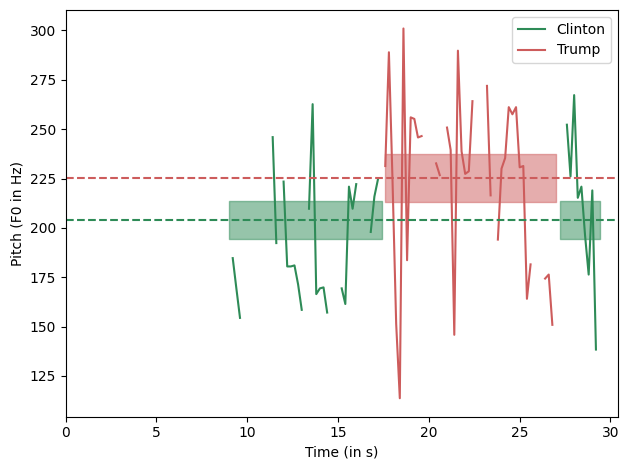

In [63]:
# Create line plot with mean and confidence bands
fig, ax = plt.subplots()

ax.plot(clinton_time.filter(clinton_time < trump_time.min()), clinton_pitch.filter(clinton_time < trump_time.min()), label='Clinton', color='seagreen')
ax.plot(clinton_time.filter(clinton_time > trump_time.max()), clinton_pitch.filter(clinton_time > trump_time.max()), color='seagreen')
ax.plot(trump_time, trump_pitch, label='Trump', color='indianred')

ax.axhline(clinton_pitch_mean.to_list(), ls='--', color='seagreen')
ax.fill_between(
    clinton_time.filter(clinton_time < trump_time.min()),
    clinton_pitch_mean+1.96*clinton_pitch_stderr,
    clinton_pitch_mean-1.96*clinton_pitch_stderr,
    color='seagreen',
    alpha=0.5,
)

ax.fill_between(
    clinton_time.filter(clinton_time > trump_time.max()),
    clinton_pitch_mean+1.96*clinton_pitch_stderr,
    clinton_pitch_mean-1.96*clinton_pitch_stderr,
    color='seagreen',
    alpha=0.5,
)
ax.axhline(trump_pitch_mean.to_list(), ls='--', color='indianred')
ax.fill_between(
    trump_time,
    trump_pitch_mean+1.96*trump_pitch_stderr,
    trump_pitch_mean-1.96*trump_pitch_stderr,
    color='indianred',
    alpha=0.5,
)

ax.set_xlabel('Time (in s)')
ax.set_xticks(np.arange(35, step=5.0))
ax.set_ylabel('Pitch (F0 in Hz)')
ax.legend()

fig.tight_layout()

plt.show()


The figure shows the voice pitch of Clinton and Trump over time and displays the mean pitch (dashed line) with confidence bands (95% CI). It shows that the baseline pitch of Trump's voice is higher on average than Clinton's. However, to draw meaningful conclusions about differences in expressed emotions, we would need to compare the pitch in specific parts of speech against the baseline (which goes beyond this example).

## Analyzing the Text

Next to facial expressions and voice features, mexca can also extract the sentiment from the spoken text. Again, we can compare the positive, negative, and neutral sentiment in the speech content between Clinton and Trump.

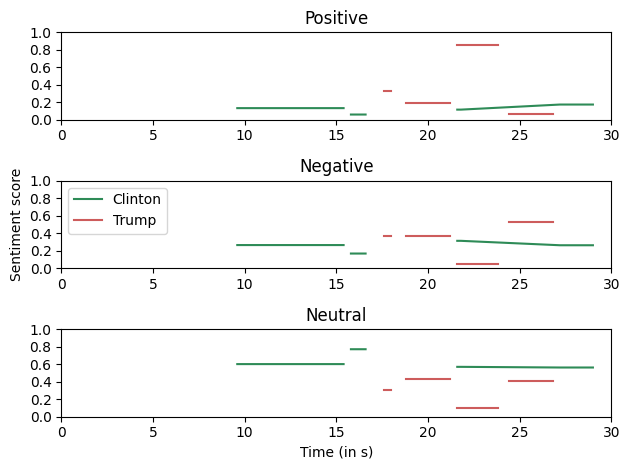

In [65]:
# Extract text sentiment
clinton_sent_pos = clinton_df.select(pl.col("span_sent_pos"))
clinton_sent_neg = clinton_df.select(pl.col("span_sent_neg"))
clinton_sent_neu = clinton_df.select(pl.col("span_sent_neu"))
trump_sent_pos = trump_df.select(pl.col("span_sent_pos"))
trump_sent_neg = trump_df.select(pl.col("span_sent_neg"))
trump_sent_neu = trump_df.select(pl.col("span_sent_neu"))

# Create line plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(clinton_time, clinton_sent_pos, label='Clinton', color='seagreen')
ax1.plot(trump_time, trump_sent_pos, label='Trump', color='indianred')
ax2.plot(clinton_time, clinton_sent_neg, label='Clinton', color='seagreen')
ax2.plot(trump_time, trump_sent_neg, label='Trump', color='indianred')
ax3.plot(clinton_time, clinton_sent_neu, label='Clinton', color='seagreen')
ax3.plot(trump_time, trump_sent_neu, label='Trump', color='indianred')

ax1.set_title('Positive')
ax2.set_title('Negative')
ax3.set_title('Neutral')
ax3.set_xlabel('Time (in s)')
for ax in (ax1, ax2, ax3):
    ax.set_xticks(np.arange(35, step=5.0))
    ax.set_yticks(np.arange(1.2, step=0.2))
ax2.set_ylabel('Sentiment score')
ax2.legend()

fig.tight_layout()

plt.show()

We can see that Clinton uses relatively neutral sentiment. Trump, in contrast, has a strongly positive peak in his turn when he talks about "the finest deal you've ever seen" and a negative peak at "all of a sudden you were against it".


## Summary

In this example, we build a custom pipeline using the mexca package to extract emotion expressions from a video. We ran the pipeline on an excerpt from the US presidential debate 2016 between Clinton and Trump. We analyzed differences in facial action unit activations, voice pitch, and speech text sentiment between the two candidates.